# Welcome to Kluster, a distributed multibeam processing framework

Kluster allows you to process multibeam data and get fully corrected georeferenced soundings.  Here, let me show you.  It just so happens that I have a multibeam file here for us to look at.

In [2]:
from HSTB.kluster import fqpr_convenience
multibeam_file = r'/home/jovyan/test_data/0009_20170523_181119_FA2806.all'

Note that Kluster currently only supports .all and .kmall files.

The multibeam file is a Kongsberg EM2040 that came off of one of the NOAA Ship Fairweather survey launches.  The fqpr_convenience is the Fully Qualified Ping Record Convenience module.  Think of this as the toolbox that has most of the tools you would need in the console.

Let's go ahead and do the all-in-one-step processing.  This will give us georeferenced soundings in a projected UTM zone with the waterline (as described in the .all file) as the vertical reference.

We are only passing in one file here, but you can also pass in a list of files or a directory of multibeam files to process.

In [3]:
dataset = fqpr_convenience.perform_all_processing(multibeam_file)

Started local cluster client...
<Client: 'tcp://127.0.0.1:41107' processes=4 threads=4, memory=8.59 GB>
****Running Kongsberg .all converter****
/home/jovyan/test_data/0009_20170523_181119_FA2806.all: Using 20 chunks of size 1962957
Operating on sector 0, s/n 40111, freq 265000
Rebalancing 108 total ping records across 1 blocks of size 1000
Operating on sector 0, s/n 40111, freq 275000
Rebalancing 108 total ping records across 1 blocks of size 1000
Operating on sector 1, s/n 40111, freq 285000
Rebalancing 108 total ping records across 1 blocks of size 1000
Operating on sector 1, s/n 40111, freq 290000
Rebalancing 108 total ping records across 1 blocks of size 1000
Operating on sector 2, s/n 40111, freq 270000
Rebalancing 108 total ping records across 1 blocks of size 1000
Operating on sector 2, s/n 40111, freq 280000
Rebalancing 108 total ping records across 1 blocks of size 1000
Rebalancing 5302 total attitude records across 1 blocks of size 20000
Rebalancing 10640 total navigation re

Now dataset equals a new Fqpr instance, containing all of our converted and raw data.  It's all written to disk right alongside our multibeam file, which is what happens if you don't specify an output directory.

In [11]:
dataset.multibeam.converted_pth

'/home/jovyan/test_data/converted'

All of our converted and processed data is written to Zarr data stores, which you can open and interact with using Xarray objects and methods.  For instance, we can examine the raw attitude by doing:

In [12]:
dataset.multibeam.raw_att

<xarray.Dataset>
Dimensions:  (time: 5302)
Coordinates:
  * time     (time) float64 1.496e+09 1.496e+09 ... 1.496e+09 1.496e+09
Data variables:
    heading  (time) float32 dask.array<chunksize=(5302,), meta=np.ndarray>
    heave    (time) float32 dask.array<chunksize=(5302,), meta=np.ndarray>
    pitch    (time) float32 dask.array<chunksize=(5302,), meta=np.ndarray>
    roll     (time) float32 dask.array<chunksize=(5302,), meta=np.ndarray>
Attributes:
    reference:  {'heading': 'reference point', 'heave': 'transmitter', 'pitch...
    units:      {'heading': 'degrees', 'heave': 'meters (+ down)', 'pitch': '...

This is an Xarray Dataset containing the heading, heave, pitch, etc. that was in the .all file and is now available for you to analyze.  Let's plot the heave just to see how significant the heave for this line was.

Units of "meters (+ down)"
Reference of "transmitter"


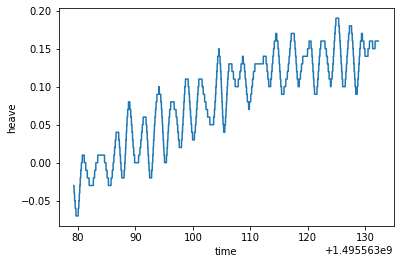

In [13]:
dataset.multibeam.raw_att.heave.plot()
print('Units of "{}"'.format(dataset.multibeam.raw_att.units['heave']))
print('Reference of "{}"'.format(dataset.multibeam.raw_att.reference['heave']))

Not too much heave here.  Note that the time here is UNIX time, in seconds.  So this little line would only be about 50 seconds long, going by the logged attitude.  How about navigation?  Our converted multibeam data should also have navigation in it.  Let's see if we can plot the altitude as well.

Units of "meters (+ down from ellipsoid)"
Reference of "reference point"


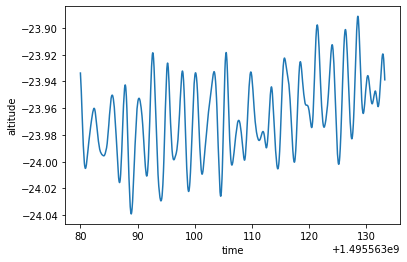

In [14]:
dataset.multibeam.raw_nav.altitude.plot()
print('Units of "{}"'.format(dataset.multibeam.raw_nav.units['altitude']))
print('Reference of "{}"'.format(dataset.multibeam.raw_nav.reference['altitude']))

Both of those look pretty good.  How about pings?  That's what we are really after, the georeferenced xyz for each sounding.  Well, admittedly this gets a little more complicated with Kluster.  Kluster will take each serial number/sector/frequency combinateion and split them up into separate datasets.  This is to allow us to use interpolation and selection by time within Xarray, as Kongsberg multibeam files will have instances where pings with different sectors or frequencies or serial numbers (dual head systems) can be at the same time, and we need to have all unique times in each Xarray Dataset.

So let's look at the ping records that we have

In [15]:
print([ping.sector_identifier for ping in dataset.multibeam.raw_ping])

['40111_0_265000', '40111_0_275000', '40111_1_285000', '40111_1_290000', '40111_2_270000', '40111_2_280000']


So you can see that unlike raw_att or raw_nav, raw_ping is actually a list of Xarray Dataset objects.  Here we have 6 of those datasets.  Let's examine the first dataset, which would be all the soundings that belong to sonar serial number 40111, sector 0, frequency 265kHz.

In [16]:
dataset.multibeam.raw_ping[0]

<xarray.Dataset>
Dimensions:              (beam: 182, time: 108, xyz: 3)
Coordinates:
  * beam                 (beam) int64 0 1 2 3 4 5 6 ... 176 177 178 179 180 181
  * time                 (time) float64 1.496e+09 1.496e+09 ... 1.496e+09
  * xyz                  (xyz) <U1 'x' 'y' 'z'
Data variables:
    acrosstrack          (time, beam) float32 dask.array<chunksize=(108, 182), meta=np.ndarray>
    alongtrack           (time, beam) float32 dask.array<chunksize=(108, 182), meta=np.ndarray>
    beampointingangle    (time, beam) float32 dask.array<chunksize=(108, 182), meta=np.ndarray>
    corr_altitude        (time) float32 dask.array<chunksize=(108,), meta=np.ndarray>
    corr_heave           (time) float32 dask.array<chunksize=(108,), meta=np.ndarray>
    corr_pointing_angle  (time, beam) float32 dask.array<chunksize=(108, 182), meta=np.ndarray>
    counter              (time) int64 dask.array<chunksize=(108,), meta=np.ndarray>
    depthoffset          (time, beam) float32 dask.array<chunksize=(108, 182), meta=np.ndarray>
    detectioninfo        (time, beam) int64 dask.array<chunksize=(108, 182), meta=np.ndarray>
    mode                 (time) <U2 dask.array<chunksize=(108,), meta=np.ndarray>
    modetwo              (time) <U4 dask.array<chunksize=(108,), meta=np.ndarray>
    ntx                  (time) uint16 dask.array<chunksize=(108,), meta=np.ndarray>
    processing_status    (time, beam) uint8 dask.array<chunksize=(108, 182), meta=np.ndarray>
    qualityfactor        (time, beam) int64 dask.array<chunksize=(108, 182), meta=np.ndarray>
    rel_azimuth          (time, beam) float32 dask.array<chunksize=(108, 182), meta=np.ndarray>
    rx                   (time, beam, xyz) float32 dask.array<chunksize=(108, 182, 3), meta=np.ndarray>
    soundspeed           (time) float32 dask.array<chunksize=(108,), meta=np.ndarray>
    thu                  (time, beam) float32 dask.array<chunksize=(108, 182), meta=np.ndarray>
    tiltangle            (time) float32 dask.array<chunksize=(108,), meta=np.ndarray>
    traveltime           (time, beam) float32 dask.array<chunksize=(108, 182), meta=np.ndarray>
    tvu                  (time, beam) float32 dask.array<chunksize=(108, 182), meta=np.ndarray>
    tx                   (time, xyz) float32 dask.array<chunksize=(108, 3), meta=np.ndarray>
    x                    (time, beam) float64 dask.array<chunksize=(108, 182), meta=np.ndarray>
    y                    (time, beam) float64 dask.array<chunksize=(108, 182), meta=np.ndarray>
    yawpitchstab         (time) <U2 dask.array<chunksize=(108,), meta=np.ndarray>
    z                    (time, beam) float32 dask.array<chunksize=(108, 182), meta=np.ndarray>
Attributes:
    _compute_beam_vectors_complete:    Wed Nov 25 16:04:51 2020
    _compute_orientation_complete:     Wed Nov 25 16:04:42 2020
    _conversion_complete:              Wed Nov 25 16:04:36 2020
    _georeference_soundings_complete:  Wed Nov 25 16:05:09 2020
    _sound_velocity_correct_complete:  Wed Nov 25 16:04:59 2020
    _total_uncertainty_complete:       Wed Nov 25 16:05:18 2020
    input_datum:                       WGS84
    installsettings_1495563079:        {"waterline_vertical_location": "-0.64...
    multibeam_files:                   {'0009_20170523_181119_FA2806.all': [1...
    output_path:                       /home/jovyan/test_data/converted
    profile_1495563079:                [[0.0, 1489.2000732421875], [0.32, 148...
    reference:                         {'acrosstrack': 'reference', 'alongtra...
    runtimesettings_1495563080:        {"Counter": "61968", "SystemSerial#": ...
    secondary_system_serial_number:    [0]
    sector_identifier:                 40111_0_265000
    sonartype:                         em2040
    status_lookup:                     {'0': 'converted', '1': 'orientation',...
    survey_number:                     ['01_Patchtest_2806']
    svmode:                            nearest in time
    system_serial_number:              [40111]
  

You can click the little arrows next to 'Data Variables' or 'Attributes' to expand.  Yikes, that is a lot of information.  Our variables are all the converted, intermediate and final processed data records.  For instance 'beampointingangle' would be the raw beam angles from the .all file, while 'corr_pointing_angle' are the kluster corrected beam angles for attitude/mounting angle.

What we are after are the x, y, z data variables.  If you just want those values in text, we can just export to csv files, where you can import them into software packages like Caris HIPS or Qimera.  Let's try it out.

In [17]:
dataset.export_pings_to_file()

****Exporting xyz data to csv****
Operating on sector 40111_0_265000
40111_0_265000: 13304 total soundings, 11757 retained, 1547 filtered
writing to /home/jovyan/test_data/converted/csv_export/40111_0_265000.xyz
Operating on sector 40111_0_275000
40111_0_275000: 13304 total soundings, 11931 retained, 1373 filtered
writing to /home/jovyan/test_data/converted/csv_export/40111_0_275000.xyz
Operating on sector 40111_1_285000
40111_1_285000: 12575 total soundings, 12573 retained, 2 filtered
writing to /home/jovyan/test_data/converted/csv_export/40111_1_285000.xyz
Operating on sector 40111_1_290000
40111_1_290000: 12575 total soundings, 12575 retained, 0 filtered
writing to /home/jovyan/test_data/converted/csv_export/40111_1_290000.xyz
Operating on sector 40111_2_270000
40111_2_270000: 17321 total soundings, 14955 retained, 2366 filtered
writing to /home/jovyan/test_data/converted/csv_export/40111_2_270000.xyz
Operating on sector 40111_2_280000
40111_2_280000: 17321 total soundings, 15092 re

You'll see there is a new 'csv_export' folder in /test_data/converted, that contains 6 new xyz files.  If you have access to Caris, Qimera or a software package that can ingest csv northing/easting/down files, try importing these, see what you get.  

One thing that you will need is the coordinate system information for our georeferenced soundings.  Getting this is simple:

In [22]:
print(type(dataset.xyz_crs))
print(dataset.xyz_crs)
print(dataset.xyz_crs.to_epsg())

<class 'pyproj.crs.crs.CRS'>
+proj=utm +zone=10N +ellps=GRS80 +datum=NAD83 +type=crs
26910


You can see that we retain the pyproj CRS object as a class attribute, so you can easily use the existing methods to get EPSG or which ever format you want.

This line is roughly 90 meters deep, so I did an 8 meter surface which seemed to look pretty good.  It's a short line, so it doesn't really look all that interesting.

We can also plot this line in Kluster/matplotlib, using the fqpr_visualizations module.  I'll mention here that plotting this many soundings can be quite slow.

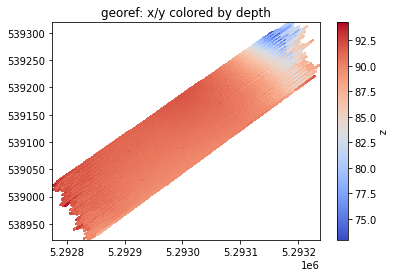

In [27]:
from HSTB.kluster.fqpr_visualizations import FqprVisualizations
fqv = FqprVisualizations(dataset)
fig = fqv.soundings_plot_2d('georef', color_by='depth')

We can also plot with different colors or even plot just the sound velocity corrected offsets (alongtrack/acrosstrack/down)

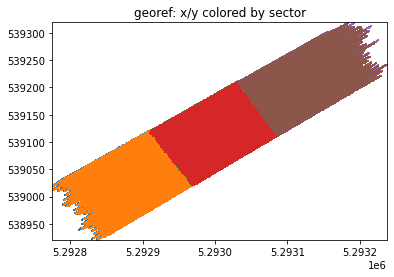

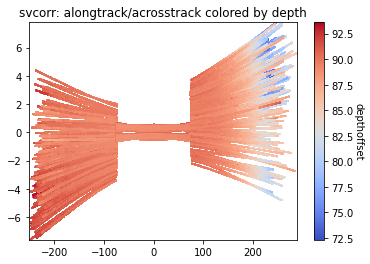

In [30]:
fig = fqv.soundings_plot_2d('georef', color_by='sector')
fig = fqv.soundings_plot_2d('svcorr', color_by='depth')

In [ ]:
The svcorr plot looks a little odd, but note that the scale of the y axis (alongtrack) is quite restricted.

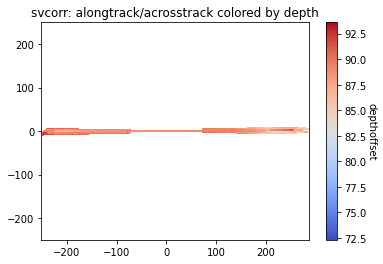

In [32]:
fig = fqv.soundings_plot_2d('svcorr', color_by='depth')
lims = fig.axes[0].set_ylim(-250,250)

That's all great, but what if we want to get an understanding of what's going on at the ping level?  I'd like to see all 400 beams for one ping here, not a bunch of datasets that have just the beams for one sector.

To reform the ping and get the full swath at a particular time, we use the following:

In [39]:
pings = dataset.reform_2d_vars_across_sectors_at_time(['x', 'y', 'z'], as_dataset=True)
pings

TypeError: reform_2d_vars_across_sectors_at_time() got an unexpected keyword argument 'as_dataset'